In [18]:
import pandas as pd
import lightgbm as lgb
import catboost
import numpy as np
from sklearn.metrics import mean_squared_log_error
import math
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization
import copy
from sklearn.preprocessing import RobustScaler

In [3]:
trainTrue = pd.read_csv('train.csv')
fulfillmentTrue = pd.read_csv('fulfilment_center_info.csv')
mealTrue = pd.read_csv('meal_info.csv')

In [3]:
pd.merge?

In [134]:
mergedData = pd.merge(pd.merge(trainTrue, fulfillmentTrue, how="left", on="center_id"), mealTrue, how = "left", on = "meal_id")

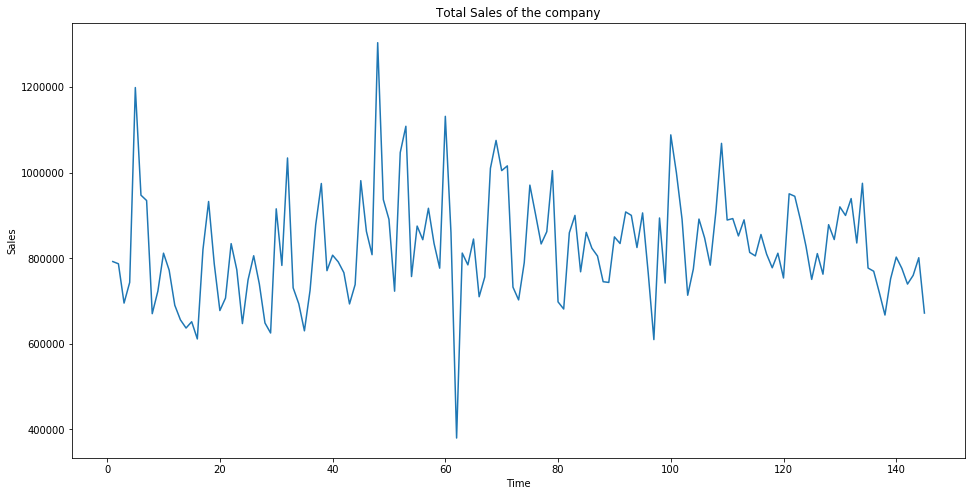

In [137]:
ts=mergedData.groupby(["week"])["num_orders"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

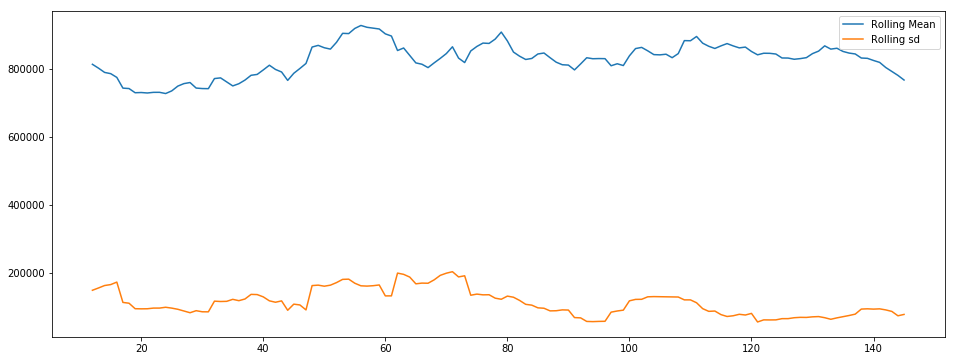

In [138]:

plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend()

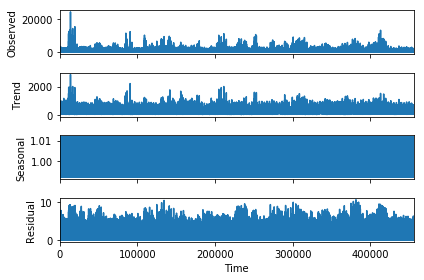

In [140]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(mergedData['num_orders'].values,freq=12,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

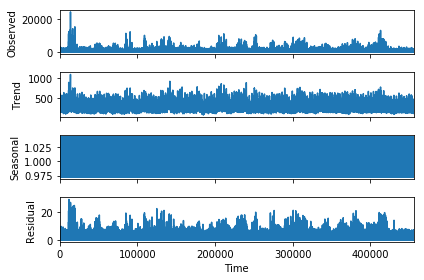

In [136]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(mergedData['num_orders'].values,freq=52,model="multiplicative")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [5]:
mergedData.shape, trainTrue.shape, fulfillmentTrue.shape, mealTrue.shape

((456548, 15), (456548, 9), (77, 5), (51, 3))

In [45]:
mergedData.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [135]:
groupA = mergedData.groupby(['week','meal_id']).size().reset_index()
groupA.columns = ['week','meal_id', 'size']
groupA[groupA['size'] == 0]

,week,meal_id,size


In [152]:
groupA[groupA['meal_id'] == 2631]['size'].values

array([71, 76, 74, 74, 74, 66, 53, 64, 72, 73, 68, 68, 64, 63, 75, 76, 74,
       75, 68, 68, 70, 64, 72, 73, 72, 72, 73, 68, 74, 73, 74, 74, 75, 74,
       75, 76, 75, 71, 75, 74, 74, 73, 72, 71, 70, 73, 74, 73, 75, 74, 71,
       74, 75, 73, 73, 72, 74, 72, 73, 75, 74, 65, 73, 75, 74, 75, 73, 74,
       74, 73, 75, 72, 71, 73, 72, 73, 75, 75, 73, 74, 73, 74, 73, 67, 74,
       73, 68, 69, 74, 74, 73, 72, 73, 74, 73, 73, 72, 73, 72, 74, 73, 73,
       62, 69, 73, 73, 73, 69, 71, 74, 72, 74, 72, 73, 71, 73, 73, 73, 71,
       71, 74, 72, 65, 73, 70, 70, 71, 74, 72, 72, 74, 72, 69, 75, 73, 73,
       72, 74, 73, 74, 69, 73, 74, 72, 73], dtype=int64)

In [156]:
uninqueMeal = np.unique(groupA['meal_id'])

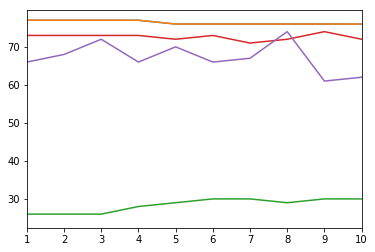

In [163]:
for meal_id in uninqueMeal[:5]:
    plt.plot(groupA[groupA['meal_id'] == meal_id]['week'], groupA[groupA['meal_id'] == meal_id]['size'].values, scalex=True)
    plt.xlim(1,10)

In [23]:
mergedData.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


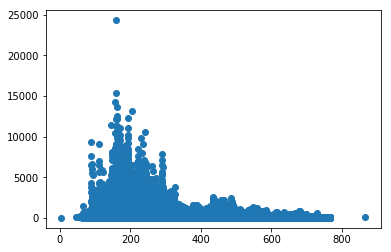

In [27]:
plt.scatter(mergedData['checkout_price'], mergedData['num_orders'])

In [58]:
mergedData = pd.merge(pd.merge(trainTrue, fulfillmentTrue, how="left", on="center_id"), mealTrue, how = "left", on = "meal_id")

mergedData_last=mergedData.loc[mergedData.groupby(['center_id','meal_id']).week.idxmax()]
mergedData_last=mergedData_last[['meal_id','center_id','num_orders']]
mergedData_last=mergedData_last.rename(columns={'num_orders':'last_order'})
mergedData_last=mergedData_last.reset_index()

In [67]:
mergedData_last.head()

,index,meal_id,center_id,last_order
0,455942,1062,10,958
1,455949,1109,10,1525
2,455965,1198,10,406
3,455944,1207,10,54
4,455957,1216,10,215


In [ ]:
mergedData.groupby(['center_id','meal_id']).week.idxmax

In [60]:
mergedData_last.head()

,index,meal_id,center_id,last_order
0,455942,1062,10,958
1,455949,1109,10,1525
2,455965,1198,10,406
3,455944,1207,10,54
4,455957,1216,10,215


In [75]:
mergedData_last3_group.reset_index()

,center_id,meal_id,num_orders
0,10,1062,1007.666667
1,10,1109,1746.666667
2,10,1198,405.333333
3,10,1207,158.000000
4,10,1216,270.333333
5,10,1230,117.666667
6,10,1247,18.666667
7,10,1248,216.333333
8,10,1311,703.000000
9,10,1438,102.666667


In [59]:
mergedData_last3=mergedData[(mergedData['week']==143) | (mergedData['week']==144) | (mergedData['week']==145) ]
mergedData_last3_group=mergedData_last3.groupby(['center_id','meal_id'])['num_orders'].mean()
mergedData_group_3=mergedData_last3_group.reset_index()
mergedData_group_3=mergedData_group_3.rename(columns={'num_orders':'avg_3_orders'})
mergedData_group=mergedData.groupby(['center_id','meal_id'])['num_orders'].mean()
mergedData_group=mergedData_group.reset_index()
mergedData_group=mergedData_group.rename(columns={'num_orders':'avg_orders'})
mergedData_new = pd.merge(mergedData, mergedData_group,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
mergedData_new = pd.merge(mergedData_new, mergedData_group_3,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
df__ = pd.merge(mergedData_new, mergedData_last,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
# df_new_2 = pd.merge(df_test, df_group,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
# df_new_2 = pd.merge(df_new_2, df_group_3,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
# df_test = pd.merge(df_new_2, df_last,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])

In [69]:
mergedData = df__

In [71]:
mergedData['avg_3_orders']=mergedData['avg_3_orders'].fillna(mergedData['avg_orders'])

In [72]:
mergedData['avg_orders'] = mergedData['avg_orders'].apply(lambda x: round(x))
mergedData['avg_3_orders'] = mergedData['avg_3_orders'].apply(lambda x: round(x))

In [50]:
mergedData['cp_cat'] = mergedData['checkout_price'].apply(lambda x: 0 if x <= 100 else
                                                         1 if 100 <= x < 150 else
                                                         2 if 150 <= x < 200 else
                                                         3 if 200 <= x < 300 else
                                                         4 if 300 <= x < 500 else
                                                         5)

In [52]:
mergedData['C'] = mergedData['checkout_price'] < mergedData['base_price']
mergedData['C'] = np.where(mergedData['C'] == True, 1, 0)

In [53]:
mergedData['lessThan300'] = np.where(mergedData['base_price'] < 300, 1, 0)
mergedData['addColumn'] = mergedData['emailer_for_promotion'] + mergedData['homepage_featured'] + mergedData['lessThan300']

In [126]:
mergedData['month'] = (mergedData['week'] // 4)
mergedData['year'] = mergedData['week'] // 52
mergedData['quarter'] = mergedData['week'] // 13
mergedData['ratio']=mergedData['checkout_price']/mergedData['base_price']
mergedData['ratio'] = mergedData['ratio'].apply(lambda x: 1 if(x<0.5) else x)

In [127]:
mergedDataProcess = mergedData.drop(['base_price', 'id', 'checkout_price'], axis = 1)
mergedDataProcess = mergedDataProcess.sample(frac=1).reset_index(drop = True)

dataX = mergedDataProcess.drop('num_orders', axis = 1)
dataY = mergedDataProcess['num_orders']
dataX = dataX.astype({'center_id':'object', 'meal_id':'object', 'city_code':'object','region_code':'object', 'op_area':'object'})
dataX = pd.get_dummies(dataX)

# X_train, X_test, Y_train, Y_test = train_test_split(dataX, dataY, test_size = 0.2, random_state = 42)

#n_estimators = 100, oob_score = True, n_jobs = -1,max_features = "auto", min_samples_leaf = 10
rnd_reg = RandomForestRegressor(n_estimators = 100, oob_score = True, n_jobs = -1,max_features = "auto", min_samples_leaf = 10,
                                random_state = 42)
rbs = RobustScaler().fit(dataX)
rnd_reg.fit(rbs.transform(dataX), dataY)

# y_pred = rnd_reg.predict(rbs.transform(X_test))
# print(100 * math.sqrt(mean_squared_log_error(Y_test, y_pred)))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [81]:
X_test.shape, testMergedProcess.shape

((91310, 251), (32573, 252))

In [83]:
testMergedProcess[]

Index(['week', 'checkout_price', 'emailer_for_promotion', 'homepage_featured',
       'avg_orders', 'avg_3_orders', 'index', 'last_order', 'cp_cat', 'C',
       ...
       'category_Rice Bowl', 'category_Salad', 'category_Sandwich',
       'category_Seafood', 'category_Soup', 'category_Starters',
       'cuisine_Continental', 'cuisine_Indian', 'cuisine_Italian',
       'cuisine_Thai'],
      dtype='object', length=252)

In [128]:
testTrue = pd.read_csv('test_QoiMO9B.csv')
# testMerged = pd.merge(pd.merge(trainTrue, fulfillmentTrue, how="left", on="center_id"), mealTrue, how = "left", on = "meal_id")
testMerged = pd.merge(pd.merge(testTrue, fulfillmentTrue, how="left", on="center_id"), mealTrue, how = "left", on = "meal_id")
# testMerged.info()


# testMerged_last=testMerged.loc[testMerged.groupby(['center_id','meal_id']).week.idxmax()]
# testMerged_last=testMerged_last[['meal_id','center_id','num_orders']]
# testMerged_last=testMerged_last.rename(columns={'num_orders':'last_order'})
# testMerged_last=testMerged_last.reset_index()

# testMerged_last3=testMerged[(testMerged['week']==143) | (testMerged['week']==144) | (testMerged['week']==145) ]
# testMerged_last3_group=testMerged_last3.groupby(['center_id','meal_id'])['num_orders'].mean()
# testMerged_group_3=testMerged_last3_group.reset_index()
# testMerged_group_3=testMerged_group_3.rename(columns={'num_orders':'avg_3_orders'})
# testMerged_group=testMerged.groupby(['center_id','meal_id'])['num_orders'].mean()
# testMerged_group=testMerged_group.reset_index()
# testMerged_group=testMerged_group.rename(columns={'num_orders':'avg_orders'})
# testMerged_new = pd.merge(testMerged, testMerged_group,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
# testMerged_new = pd.merge(testMerged_new, testMerged_group_3,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
# df__ = pd.merge(testMerged_new, testMerged_last,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
# df_new_2 = pd.merge(df_test, df_group,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
# df_new_2 = pd.merge(df_new_2, df_group_3,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
# df_test = pd.merge(df_new_2, df_last,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])


testMerged['cp_cat'] = testMerged['checkout_price'].apply(lambda x: 0 if x <= 100 else
                                                         1 if 100 <= x < 150 else
                                                         2 if 150 <= x < 200 else
                                                         3 if 200 <= x < 300 else
                                                         4 if 300 <= x < 500 else
                                                         5)

testMerged['C'] = testMerged['checkout_price'] < testMerged['base_price']
testMerged['C'] = np.where(testMerged['C'] == True, 1, 0)

testMerged['lessThan300'] = np.where(testMerged['base_price'] < 300, 1, 0)
testMerged['addColumn'] = testMerged['emailer_for_promotion'] + testMerged['homepage_featured'] + testMerged['lessThan300']

testMerged['month'] = (testMerged['week'] // 4)
testMerged['year'] = testMerged['week'] // 52
testMerged['quarter'] = testMerged['week'] // 13
testMerged['ratio']=testMerged['checkout_price']/testMerged['base_price']
testMerged['ratio'] = testMerged['ratio'].apply(lambda x: 1 if(x<0.5) else x)



df_new_2 = pd.merge(testMerged, mergedData_group,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
df_new_2 = pd.merge(df_new_2, mergedData_group_3,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
df_test = pd.merge(df_new_2, mergedData_last,  how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])




df_test['avg_3_orders']=df_test['avg_3_orders'].fillna(df_test['avg_orders'])

avg=mergedData['num_orders'].median()
df_test=df_test.fillna(avg)
df_test['avg_orders'] = df_test['avg_orders'].apply(lambda x: round(x))
df_test['avg_3_orders'] = df_test['avg_3_orders'].apply(lambda x: round(x))





# Data Processing Common Test and Train
testMergedProcess = df_test.drop(['base_price', 'id', 'checkout_price'], axis = 1)
testMergedProcess = testMergedProcess.astype({'center_id':'object', 'meal_id':'object', 'city_code':'object','region_code':'object', 'op_area':'object'})
testMergedProcess = pd.get_dummies(testMergedProcess)

#rbs = RobustScaler().fit(dataX)
# rndFull = RandomForestRegressor().fit(rbs.transform(dataX), dataY)
testDataPred = rnd_reg.predict(rbs.transform(testMergedProcess))


ValueError: operands could not be broadcast together with shapes (32573,253) (254,) (32573,253) 

In [130]:
dataX.shape, testMergedProcess.shape

((456548, 254), (32573, 253))

In [132]:
print(dataX.columns)

Index(['week', 'emailer_for_promotion', 'homepage_featured', 'cp_cat', 'C',
       'lessThan300', 'addColumn', 'month', 'weekOfMonth', 'avg_orders',
       ...
       'category_Rice Bowl', 'category_Salad', 'category_Sandwich',
       'category_Seafood', 'category_Soup', 'category_Starters',
       'cuisine_Continental', 'cuisine_Indian', 'cuisine_Italian',
       'cuisine_Thai'],
      dtype='object', length=254)


In [133]:
print(testMergedProcess.columns)

Index(['week', 'emailer_for_promotion', 'homepage_featured', 'cp_cat', 'C',
       'lessThan300', 'addColumn', 'month', 'year', 'quarter',
       ...
       'category_Rice Bowl', 'category_Salad', 'category_Sandwich',
       'category_Seafood', 'category_Soup', 'category_Starters',
       'cuisine_Continental', 'cuisine_Indian', 'cuisine_Italian',
       'cuisine_Thai'],
      dtype='object', length=253)


In [131]:
a = testMergedProcess.columns == dataX.columns

ValueError: Lengths must match to compare

In [ ]:
a

In [117]:
dataX.head()

,week,emailer_for_promotion,homepage_featured,cp_cat,C,lessThan300,addColumn,month,weekOfMonth,avg_orders,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,88,0,0,2,1,1,1,8,3,253,...,0,0,0,0,0,0,0,0,1,0
1,75,0,0,1,0,1,1,5,0,75,...,0,0,0,0,0,0,0,0,0,1
2,79,0,0,5,1,0,0,6,4,142,...,0,0,0,1,0,0,1,0,0,0
3,93,0,0,4,0,0,0,9,3,45,...,0,0,0,0,0,0,0,1,0,0
4,78,0,0,3,0,1,1,6,3,250,...,0,0,0,0,0,0,0,0,0,1


In [105]:
testMergedProcess.head()

,week,emailer_for_promotion,homepage_featured,cp_cat,C,lessThan300,addColumn,month,weekOfMonth,avg_orders,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,146,0,0,2,1,1,1,9,1,230,...,0,0,0,0,0,0,0,0,0,1
1,146,0,0,2,0,1,1,9,1,247,...,0,0,0,0,0,0,0,0,0,1
2,146,0,0,2,1,1,1,9,1,191,...,0,0,0,0,0,0,0,0,0,1
3,146,0,0,2,0,1,1,9,1,56,...,0,0,0,0,0,0,0,1,0,0
4,146,0,0,2,0,1,1,9,1,45,...,0,0,0,0,0,0,0,1,0,0


In [90]:
testTrue.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1028232,146,55,1885,158.11,159.11,0,0,24.096165
1,1127204,146,55,1993,160.11,159.11,0,0,24.601400
2,1212707,146,55,2539,157.14,159.14,0,0,24.096165
3,1082698,146,55,2631,162.02,162.02,0,0,24.702329
4,1400926,146,55,1248,163.93,163.93,0,0,24.702329


In [85]:
testDataPred.shape

(32573,)

In [86]:
testTrue.shape

(32573, 8)

In [123]:
testTrue['num_orders'] = testDataPred
testTrue[['id', 'num_orders']].to_csv('Predictions3.csv', index = False)

In [40]:
mergedData.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,cp_cat,C
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,1,1
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,1,0
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai,1,1
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian,4,1
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian,3,0


In [41]:
mergedData[['cp_cat', 'checkout_price', 'C', 'base_price']].corr()

,cp_cat,checkout_price,C,base_price
cp_cat,1.000000,0.894882,-0.113443,0.847476
checkout_price,0.894882,1.000000,-0.103340,0.953389
C,-0.113443,-0.103340,1.000000,0.043064
base_price,0.847476,0.953389,0.043064,1.000000


In [8]:
mergedData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
id                       456548 non-null int64
week                     456548 non-null int64
center_id                456548 non-null int64
meal_id                  456548 non-null int64
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
num_orders               456548 non-null int64
city_code                456548 non-null int64
region_code              456548 non-null int64
center_type              456548 non-null object
op_area                  456548 non-null float64
category                 456548 non-null object
cuisine                  456548 non-null object
dtypes: float64(3), int64(9), object(3)
memory usage: 55.7+ MB


In [17]:
mergedData.hist?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F45871B550>,
      dtype=object)

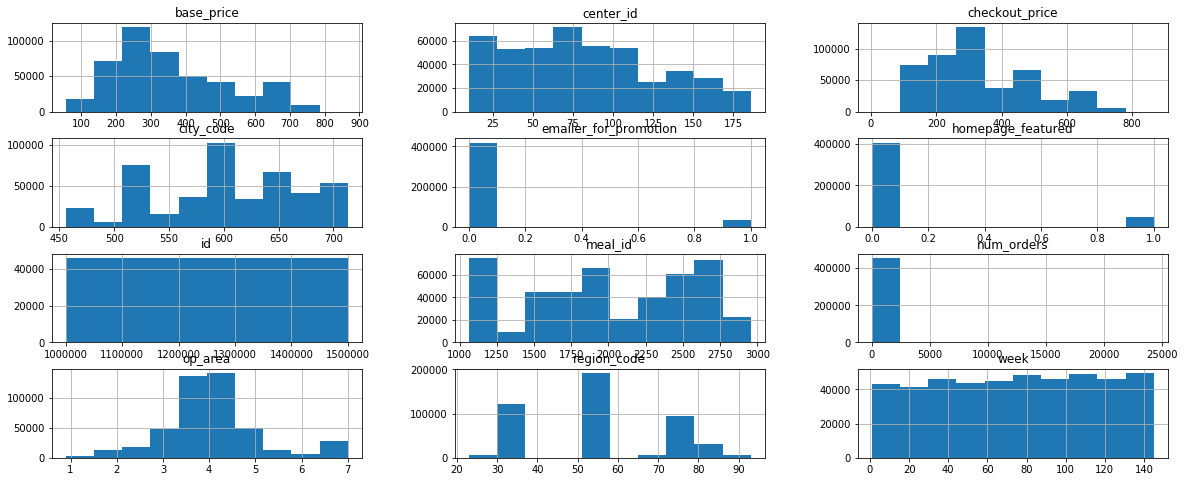

In [19]:
# plt.figure(figsize = (12,8))
(mergedData.hist(figsize=(20,8)))
# plt.show()

In [22]:
catColumns = ['center_type', 'category', 'cuisine', 'op_area', 'region_code']

for col in catColumns:
    print(col)
    print(mergedData[col].value_counts())

center_type
TYPE_A    262881
TYPE_C     99593
TYPE_B     94074
Name: center_type, dtype: int64
category
Beverages       127890
Rice Bowl        33408
Sandwich         33291
Pizza            33138
Starters         29941
Other Snacks     29379
Desert           29294
Salad            28559
Pasta            27694
Seafood          26916
Biryani          20614
Extras           13562
Soup             12675
Fish             10187
Name: category, dtype: int64
cuisine
Italian        122925
Thai           118216
Indian         112612
Continental    102795
Name: cuisine, dtype: int64
op_area
4.0    52548
3.9    48533
3.8    40080
4.4    26060
4.5    25688
2.8    25503
4.1    23346
7.0    20686
4.8    18648
3.4    17258
3.6    16821
5.1    13366
4.2    12608
2.7    12430
3.0    11184
2.0     9512
6.7     7046
6.3     7015
5.6     6993
3.7     6801
3.5     6666
3.2     6333
5.0     6164
5.3     6053
4.6     5983
4.7     5975
2.4     5021
2.9     4712
1.9     4083
0.9     3432
Name: op_area, dtype: i

In [25]:
import seaborn as sns

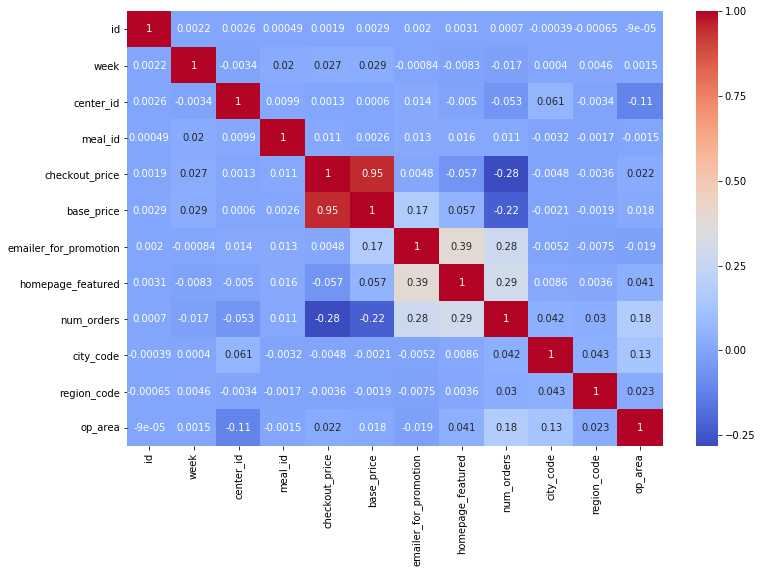

In [27]:
plt.figure(figsize=(12,8))
sns.heatmap(mergedData.corr(), cmap = "coolwarm", annot = True)
plt.show()

In [40]:


# a = mergedData['base_price']
mergedDataScaled = RobustScaler().fit_transform(mergedData['base_price'].values.reshape(-1,1))

(array([1.85370e+04, 7.07190e+04, 1.18989e+05, 8.38270e+04, 5.05950e+04,
        4.18240e+04, 2.16040e+04, 4.17020e+04, 8.74300e+03, 8.00000e+00]),
 array([-1.18451966, -0.80799554, -0.43147142, -0.0549473 ,  0.32157682,
         0.69810094,  1.07462506,  1.45114919,  1.82767331,  2.20419743,
         2.58072155]),
 <a list of 10 Patch objects>)

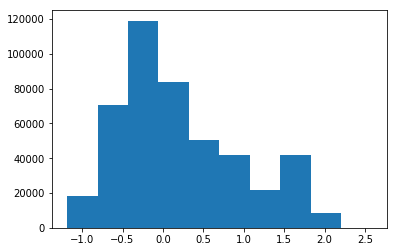

In [41]:
plt.hist(mergedDataScaled)

In [48]:
mergedData.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


### One Step Model

In [49]:
mergedDataProcess = mergedData.drop(['base_price', 'id'], axis = 1)
mergedDataProcess = mergedDataProcess.sample(frac=1).reset_index(drop = True)

dataX = mergedDataProcess.drop('num_orders', axis = 1)
dataY = mergedDataProcess['num_orders']
dataX = dataX.astype({'center_id':'object', 'meal_id':'object', 'city_code':'object','region_code':'object', 'op_area':'object'})
dataX = pd.get_dummies(dataX)

X_train, X_test, Y_train, Y_test = train_test_split(dataX, dataY, test_size = 0.2, random_state = 42)

#n_estimators = 100, oob_score = True, n_jobs = -1,max_features = "auto", min_samples_leaf = 10
rnd_reg = RandomForestRegressor(n_estimators = 100, oob_score = True, n_jobs = -1,max_features = "auto", min_samples_leaf = 10,
                                random_state = 42)
rbs = RobustScaler().fit(X_train)
rnd_reg.fit(rbs.transform(X_train), Y_train)

y_pred = rnd_reg.predict(rbs.transform(X_test))
print(100 * math.sqrt(mean_squared_log_error(Y_test, y_pred)))

49.11564566451154


### Basic processing

In [6]:
mergedDataProcess = mergedData.drop(['base_price', 'id'], axis = 1)

In [7]:
mergedDataProcess.head()

,week,center_id,meal_id,checkout_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1,55,1885,136.83,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1,55,1993,136.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai
2,1,55,2539,134.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai
3,1,55,2139,339.50,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian
4,1,55,2631,243.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian


In [47]:
mergedDataProcess.reset_index?

In [8]:
mergedDataProcess = mergedDataProcess.sample(frac=1).reset_index(drop = True)

In [9]:
dataX = mergedDataProcess.drop('num_orders', axis = 1)
dataY = mergedDataProcess['num_orders']

In [10]:
dataX = dataX.astype({'center_id':'object', 'meal_id':'object', 'city_code':'object','region_code':'object', 'op_area':'object'})

In [113]:
dataX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 12 columns):
week                     456548 non-null int64
center_id                456548 non-null object
meal_id                  456548 non-null object
checkout_price           456548 non-null float64
emailer_for_promotion    456548 non-null int64
homepage_featured        456548 non-null int64
city_code                456548 non-null object
region_code              456548 non-null object
center_type              456548 non-null object
op_area                  456548 non-null object
category                 456548 non-null object
cuisine                  456548 non-null object
dtypes: float64(1), int64(3), object(8)
memory usage: 41.8+ MB


In [11]:
dataX = pd.get_dummies(dataX)

In [115]:
dataX.head()

,week,checkout_price,emailer_for_promotion,homepage_featured,center_id_10,center_id_11,center_id_13,center_id_14,center_id_17,center_id_20,...,category_Rice Bowl,category_Salad,category_Sandwich,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai
0,141,151.38,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,52,641.23,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,141,149.41,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,43,340.53,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,39,244.50,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


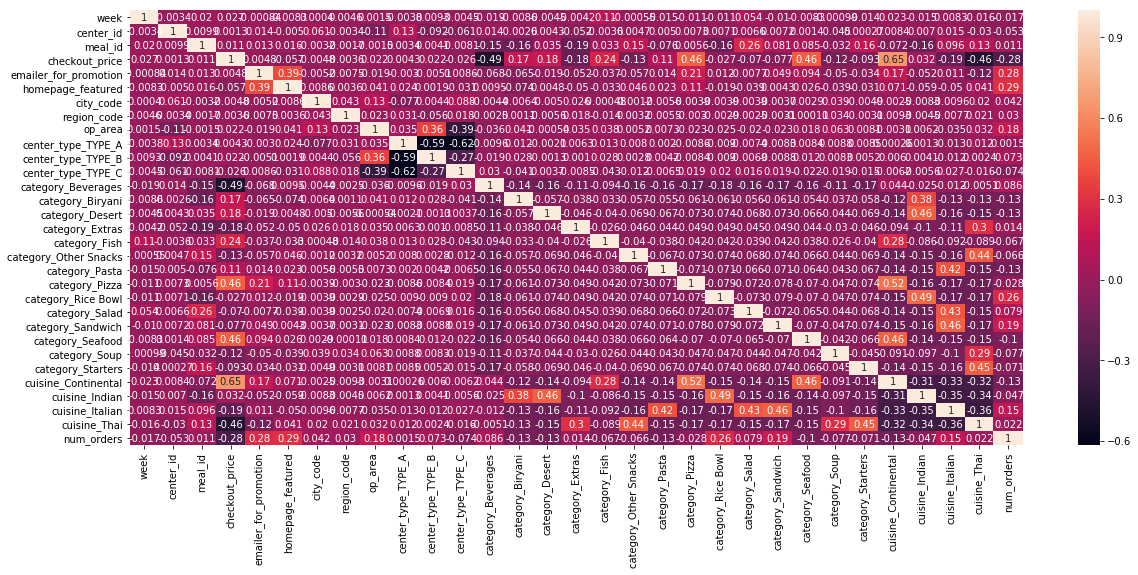

In [68]:
plt.figure(figsize=(20,8))
sns.heatmap(pd.concat([dataX, dataY], axis = 1).corr(), annot = True)
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(dataX, dataY, test_size = 0.2)

In [14]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((365238, 242), (91310, 242), (365238,), (91310,))

In [15]:
from sklearn.ensemble import RandomForestRegressor

In [19]:
rnd_reg = RandomForestRegressor()
rbs = RobustScaler().fit(X_train)
rnd_reg.fit(rbs.transform(X_train), Y_train)

c:\users\sarthak.agarwal\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [20]:
y_pred = rnd_reg.predict(rbs.transform(X_test))

In [62]:
y_pred

array([398.3,  46.6,  40.8, ...,  38.5,  52.2, 130.2])

In [63]:
Y_test

73151      377
155554      28
326353     135
340811      53
162677     270
340150      15
72604      580
165186      15
159134    1013
377076     756
85776      161
308732     189
79339      285
156773      96
58498       42
308966      82
318016     175
370243     123
279028     134
77308      257
7015       150
320484     121
375414     122
216876    6426
283387     121
365543     177
16961       15
235446     258
305736     230
404667     283
          ... 
379674      95
355063     175
372455     121
340639      82
345067     474
333042     487
18179      258
68090       81
287963     270
189380      95
175693      96
410515      14
288026      26
244975     364
347024     582
329919     121
214944     270
121546      82
138634     202
76401      526
372092     149
84585       27
93167       14
400361      40
28672      837
370069     177
419611     971
452052      40
316852      55
67477       69
Name: num_orders, Length: 91310, dtype: int64

In [21]:

100 * math.sqrt(mean_squared_log_error(Y_test, y_pred))

49.94736598382461

In [76]:
RandomForestRegressor?

In [22]:
def rndForestRMLSE(max_depth,n_estimators):
#     cv = StratifiedKFold(Y, n_folds=8,shuffle=True, random_state=30)
    rnd1 = RandomForestRegressor(max_depth=int(max_depth),n_estimators=int(n_estimators))
#                                              num_leaves=int(num_leaves),reg_alpha=reg_alpha,
#                                            reg_lambda=reg_lambda)
    rnd1.fit(rbs.transform(X_train), Y_train)
    return - 100 * math.sqrt(mean_squared_log_error(Y_test, rnd1.predict(rbs.transform(X_test))))

rndBO = BayesianOptimization(rndForestRMLSE,{'max_depth': (4, 10),'n_estimators': (10, 1000)})
#                                   'num_leaves': (4,30),'reg_alpha': (1, 5),'reg_lambda': (0, 0.1)})

rndBO.maximize()
print('-'*53)
print('Final Results')
print('XGBOOST: %f' % rndBO.res['max']['max_val'])

|   iter    |  target   | max_depth | n_esti... |
-------------------------------------------------
|  1        | -97.29    |  5.295    |  709.4    |
|  2        | -77.34    |  9.288    |  637.2    |
|  3        | -81.47    |  8.224    |  972.8    |
|  4        | -104.2    |  4.616    |  71.86    |
|  5        | -97.29    |  5.508    |  579.1    |
|  6        | -77.38    |  9.353    |  637.3    |
|  7        | -81.48    |  8.306    |  637.3    |
|  8        | -77.39    |  9.512    |  637.2    |
|  9        | -77.37    |  9.397    |  637.2    |
|  10       | -77.39    |  9.481    |  636.9    |


KeyboardInterrupt: 

In [78]:
testTrue = pd.read_csv('test_QoiMO9B.csv')
# mergedData = pd.merge(pd.merge(trainTrue, fulfillmentTrue, how="left", on="center_id"), mealTrue, how = "left", on = "meal_id")
testMerged = pd.merge(pd.merge(testTrue, fulfillmentTrue, how="left", on="center_id"), mealTrue, how = "left", on = "meal_id")
testMerged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 0 to 32572
Data columns (total 14 columns):
id                       32573 non-null int64
week                     32573 non-null int64
center_id                32573 non-null int64
meal_id                  32573 non-null int64
checkout_price           32573 non-null float64
base_price               32573 non-null float64
emailer_for_promotion    32573 non-null int64
homepage_featured        32573 non-null int64
city_code                32573 non-null int64
region_code              32573 non-null int64
center_type              32573 non-null object
op_area                  32573 non-null float64
category                 32573 non-null object
cuisine                  32573 non-null object
dtypes: float64(3), int64(8), object(3)
memory usage: 3.7+ MB


In [121]:
# Data Processing Common Test and Train
testMergedProcess = testMerged.drop(['base_price', 'id'], axis = 1)
testMergedProcess = testMergedProcess.astype({'center_id':'object', 'meal_id':'object', 'city_code':'object','region_code':'object', 'op_area':'object'})
testMergedProcess = pd.get_dummies(testMergedProcess)

In [122]:
rbs = RobustScaler().fit(dataX)
rndFull = RandomForestRegressor().fit(rbs.transform(dataX), dataY)
testDataPred = rndFull.predict(rbs.transform(testMergedProcess))

c:\users\sarthak.agarwal\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [123]:
testDataPred

array([115.9,  71.6, 149.7, ..., 351.6, 381.6, 145.7])

In [124]:
testTrue['num_orders'] = testDataPred

In [125]:
testTrue[['id', 'num_orders']].to_csv('Predictions.csv', index = False)